<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.CrowdCounting/blob/main/1_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
import pandas as pd

from keras import backend as K
from keras.utils.layer_utils import count_params

In [ ]:
from tensorflow.keras.applications import resnet50
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
)
from tensorflow.keras.models import Model


# PEP8 standard

In [ ]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

# Custom packages

In [ ]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [ ]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager

# Setup paths

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/7.CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Models/trial_1 already exists


# Helper functions

In [ ]:
def count_parameters(model):
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    return {
        'Total parameters': trainable_count + non_trainable_count,
        'Trainable parameters': trainable_count,
        'Non-trainable parameters': non_trainable_count
    }

In [ ]:
def collect_comparison_data(models_dict_):
    validation_results = {}
    model_parameters = {}

    for model_name, model_object in MODELS.items():
        print(f'Working with {model_name}')

        model_object.prepare_model()
        model_object.compile_model()

        model_object.model.load_weights(
            os.path.join(
                manager.models_trial_path,
                model_object.name,
                model_object.name
            )
        )
        validation_results[model_name] = model_object.model.evaluate(
            model_object.validation_generator
        )
        model_parameters[model_name] = count_parameters(model_object.model)
        
    return {
        'validation_results': validation_results,
        'model_parameters': model_parameters
    }

In [ ]:
def plot_validation_results(validation_performance_dict_):
    mae_dict = {
        model_name: [data[2]] \
        for model_name, data in validation_performance_dict_.items()
    }
    
    df = pd.DataFrame(mae_dict, index=None)
    df = df.T
    print(df)
    df = df.sort_values(by=0)
    
    fontsize = 14
    labelsize = 14
    ax = df.plot(kind='bar')
    ax.set_ylabel('Validation MAE', fontsize=fontsize)
    ax.set_xlabel('Model', fontsize=fontsize)
    ax.set_title('Validation performance of baseline models', fontsize=fontsize)
    ax.legend(prop={'size': fontsize})
    ax.tick_params(labelsize=labelsize)
    ax.get_legend().remove()
    ax.grid()
    plt.xticks(rotation=45)

In [ ]:
def plot_model_parameters(parameters_dict_):
    total_parameters_dict = {
        model_name: [model_dict['Total parameters']] \
        for model_name, model_dict in parameters_dict_.items()
    }

    trainable_parameters_dict = {
        model_name: [model_dict['Trainable parameters']] \
        for model_name, model_dict in parameters_dict_.items()
    }

    _, ax = plt.subplots(1, 2, figsize=(14, 8))

    fontsize = 14
    labelsize = 14
    
    df_total_parameters = pd.DataFrame(total_parameters_dict)
    df_total_parameters = df_total_parameters.T
    df_total_parameters.sort_values(by=0, inplace=True)
    df_total_parameters.plot(kind='bar', ax=ax[0], fontsize=fontsize)
    ax[0].set_title('Total number of model parameters', fontsize=fontsize)
    ax[0].grid()
    ax[0].get_legend().remove()

    df_trainable_parameters = pd.DataFrame(trainable_parameters_dict)
    df_trainable_parameters = df_trainable_parameters.T
    df_trainable_parameters.sort_values(by=0, inplace=True)
    df_trainable_parameters.plot(kind='bar', ax=ax[1], fontsize = 14)

    

    ax[1].set_title(
        'Number of trainable parameters' \
        + '\nfor baseline ' \
        + 'models\n(with 7 top layers unfreezed)',
        fontsize=fontsize
    )
    ax[1].grid()
    ax[1].get_legend().remove()
    plt.tick_params(rotation=45, axis='x')

    plt.tight_layout()

In [ ]:
def compare_learning_curve(
    csv_dict_,
    metrics_
):

    fontsize = 20
    legendsize = 16

    _, ax = plt.subplots(figsize=(10, 7))
    for model_name, csv_filepath in csv_dict_.items():
        assert os.path.isfile(csv_filepath)
        df = pd.read_csv(csv_filepath)
        assert metrics_ in df.columns

        data = df[metrics_]
        ax.plot(data, label=model_name, marker='o', markersize=4)
    ax.legend(prop={'size': legendsize})
    ax.grid()

    ax.set_xlabel('Epoch', fontsize=fontsize)
    ax.set_ylabel(metrics_, fontsize=fontsize)
    ax.set_title(f'{metrics_} VS epoch for baseline models', fontsize=fontsize)
    
    ax.tick_params(labelsize=17)

In [ ]:
def visualize_training_times(training_times_dict_):
    _, ax = plt.subplots(1, 2, figsize=(16, 4))
    fontsize=16
    legendsize=11
    labelsize=14
    
    for model_name, training_time in training_times_dict_.items():
        ax[0].plot(
            training_time[1:],
            label=model_name,
            marker='o',
            markersize=5
            # linestyle='--'
        )
    ax[0].grid()
    ax[0].set_title(
        'Time per epoch for baseline models' \
        + '\n(Starting from 2nd epoch)',
        fontsize=fontsize
    )
    ax[0].set_ylabel('Time, sec', fontsize=fontsize)
    ax[0].set_xlabel(f'Epoch', fontsize=fontsize)
    ax[0].legend(prop={'size': legendsize})
    ax[0].tick_params(labelsize=labelsize)
    # bbox_to_anchor=(1.1, 1.05)
    

    first_epoch_dt_dict = {
        model_name: [times[0]] \
        for model_name, times in training_times_dict_.items()
    }
    df = pd.DataFrame(first_epoch_dt_dict)
    df = df.T
    df.sort_values(by=0, inplace=True)
    df.plot(kind='bar', ax=ax[1])
    ax[1].get_legend().remove()
    ax[1].tick_params(labelrotation=45, axis='x')
    ax[1].grid()
    ax[1].set_title(f'Time of the first epoch', fontsize=fontsize)
    ax[1].set_ylabel(f'Time, sec', fontsize=fontsize)
    ax[1].set_xlabel(f'Model', fontsize=fontsize)
    ax[1].tick_params(labelsize=labelsize)

In [ ]:
def plot_validation_performance_vs_unfreezed_layers(metrics_):
    validation_performances = {}
    for model_name, csv_filepath in csv_files_dict.items():
        n_unfreezed_layers = int(model_name.split('_')[1])
        learning_curve_df = pd.read_csv(
            os.path.join(manager.models_trial_path, csv_filepath))
        final_metrics = learning_curve_df[metrics_].values[-1]
        validation_performances[n_unfreezed_layers] = [final_metrics]

    df = pd.DataFrame(validation_performances)
    df = df.T
    fontsize = 14
    labelsize = 12
    # df.sort_values(by=0, inplace=True)        
    ax = df.plot(kind='bar')
    ax.set_xlabel(f'Number of unfrozen layers', fontsize=fontsize)
    ax.set_ylabel(f'Validation performance (MAE)', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize, labelrotation=0)

    ax.get_legend().remove()
    ax.grid()
    ax.set_title(f'Validation performance VS number\nof unfreezed layers for Xception architecture', fontsize=fontsize)

In [ ]:
def plot_number_of_trainable_parameters(
    model_class_,
    model_params_dict_,
    n_unfreezed_layers_list_
):
    fontsize = 14
    labelsize = 12
    plot_data = {}
    for n_unfreezed_layers in n_unfreezed_layers_list_:
        model = model_class_(
            **model_params_dict_
        )
        model.prepare_model()
        model.unfreeze_n_layers(n_unfreezed_layers)
        params_dict = count_parameters(model.model)
        trainable_parameters = params_dict['Trainable parameters']
        plot_data[n_unfreezed_layers] = [trainable_parameters]
    
    df = pd.DataFrame(plot_data).T
    ax = df.plot(kind='bar', fontsize=fontsize)
    ax.get_legend().remove()
    ax.grid()
    ax.tick_params(labelrotation=0)
    ax.set_title(f'Number of trainable parameters \nVS unfreezed layers', fontsize=fontsize)
    ax.set_xlabel(f'Number of unfreezed layers (from top)', fontsize=fontsize)
    ax.set_ylabel(f'Number of trainable parameters', fontsize=fontsize)

In [ ]:
def plot_history(csv_filepaths_dict_, metrics_, title_=''):
    _, ax = plt.subplots()

    fontsize = 14
    legendsize = 11
    labelsize = 12

    for model_name, path in csv_filepaths_dict_.items():
        assert os.path.isfile(path)
        df = pd.read_csv(path)
        ax.plot(df[metrics_], label=f'{model_name} {metrics_}', marker='o', markersize=2)
        ax.plot(df[f'val_{metrics_}'], label=f'{model_name} val_{metrics_}', marker='o', markersize=2)
    
    ax.set_ylabel(f'Learning curve for {metrics_}', fontsize=fontsize)
    ax.set_xlabel(f'Epoch', fontsize=fontsize)
    ax.set_title(title_)
    ax.tick_params(labelsize=labelsize)
    ax.grid()
    ax.legend(prop={'size':legendsize})

# Data split

In [ ]:
frames_directory = os.path.join(manager.data_root_path, 'frames')
labels_df = pd.read_csv(os.path.join(manager.data_root_path, 'labels.csv'))
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
print(labels_df.head(1))

   id  count      image_name
0   1     35  seq_000001.jpg


In [ ]:
TRAINVAL_SIZE = 0.2  # 0.8
RANDOM_STATE = 42

trainval_labels_df, test_labels_df = train_test_split(
    labels_df,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
)
trainval_labels_df.shape, test_labels_df.shape

((400, 3), (1600, 3))

# Classes definition

In [ ]:
class NNModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_
        self.validation_split = validation_split_
        self.batch_size = batch_size_


        self.data_generator_parameters = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators(
            trainval_labels_df_,
            test_labels_df_
        )
    
    def __repr__(self):
        return f'''
            {
                self.random_state,
                self.name,
                self.input_image_size,
                self.validation_split,
                self.batch_size
            }
        '''
    @abstractmethod
    def init_data_generator_parameters(self):
        # Augmentation / preprocessing parameters
        pass
    
    def init_data_generators(self, trainval_labels_df_, test_labels_df_):
        trainval_data_generator = ImageDataGenerator(
            **self.data_generator_parameters,
            validation_split=self.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.data_generator_parameters)
        
        common_flow_params = dict(
            directory=frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='training',
            dataframe=trainval_labels_df_
        )

        self.validation_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='validation',
            dataframe=trainval_labels_df_
        )

        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_flow_params,
            dataframe=test_labels_df_
        )

    def visualize_data(self):
        X_batch, Y_batch = next(self.train_generator)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3)
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax.hist.hist(Y_batch)
        
    @abstractmethod
    def prepare_model(self):
        pass

    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0

        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True
    
    def fit(self, epochs_, callbacks_):
        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

## Resnet

In [ ]:
class ResNetModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = resnet50.ResNet50(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


class InceptionV3Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = InceptionV3(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## Inception Resnet V2

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


class InceptionResnetV2Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.\
                keras.\
                applications.\
                inception_resnet_v2.\
                preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = InceptionResNetV2(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


class VGG16Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        print(f'VGG16: init data generator parameters')
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.vgg16.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = VGG16(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19


class VGG19Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=\
                tf.keras.applications.vgg19.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = VGG19(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

# Comparison of validation performance

In [ ]:
common_params = dict(
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

MODELS = {
    'resnet': ResNetModel(
        name_='resnet',
        input_image_size_=(224, 224),
        **common_params
    ),
    'xception': XceptionModel(
        name_='xception',
        input_image_size_=(299, 299),
        **common_params
    ),
    'inception_v3': InceptionV3Model(
        name_='inception_v3',
        input_image_size_=(299, 299),
        **common_params
    ),
    'inception_resnet_v2': InceptionResnetV2Model(
        name_='inception_resnet_v2',
        input_image_size_=(299, 299),
        **common_params
    ),
    'vgg16': VGG16Model(
        name_='vgg16',
        input_image_size_=(224, 224),
        **common_params
    ),
    'vgg19': VGG19Model(
        name_='vgg19',
        input_image_size_=(224, 224),
        **common_params
    )
}

Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
VGG16: init data generator parameters
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.


In [ ]:
comparison_data = collect_comparison_data(MODELS)

Working with resnet
2/2 [==============================] - 16s 2s/step - loss: 8.1138 - mse: 8.1138 - mae: 2.2562
Working with xception
2/2 [==============================] - 35s 5s/step - loss: 9.3450 - mse: 9.3450 - mae: 2.3724
Working with inception_v3
2/2 [==============================] - 19s 3s/step - loss: 8.4677 - mse: 8.4677 - mae: 2.2880
Working with inception_resnet_v2
2/2 [==============================] - 47s 7s/step - loss: 7.8980 - mse: 7.8980 - mae: 2.2554
Working with vgg16
58889256/58889256 [==============================] - 3s 0us/step


2/2 [==============================] - 45s 8s/step - loss: 18.7580 - mse: 18.7580 - mae: 3.6233
Working with vgg19
80134624/80134624 [==============================] - 4s 0us/step


2/2 [==============================] - 53s 10s/step - loss: 11.7061 - mse: 11.7061 - mae: 2.5696


In [ ]:
comparison_data

{'validation_results': {'resnet': [8.113811492919922,
   8.113811492919922,
   2.2562203407287598],
  'xception': [9.344964981079102, 9.344964981079102, 2.3723535537719727],
  'inception_v3': [8.467727661132812, 8.467727661132812, 2.288046360015869],
  'inception_resnet_v2': [7.897987365722656,
   7.897987365722656,
   2.255380630493164],
  'vgg16': [18.758041381835938, 18.758041381835938, 3.623260974884033],
  'vgg19': [11.706084251403809, 11.706084251403809, 2.569606304168701]},
 'model_parameters': {'resnet': {'Total parameters': 24568113,
   'Trainable parameters': 24514993,
   'Non-trainable parameters': 53120},
  'xception': {'Total parameters': 21841881,
   'Trainable parameters': 21787353,
   'Non-trainable parameters': 54528},
  'inception_v3': {'Total parameters': 22783185,
   'Trainable parameters': 22748753,
   'Non-trainable parameters': 34432},
  'inception_resnet_v2': {'Total parameters': 55112337,
   'Trainable parameters': 55051793,
   'Non-trainable parameters': 60544

                            0
resnet               2.256220
xception             2.372354
inception_v3         2.288046
inception_resnet_v2  2.255381
vgg16                3.623261
vgg19                2.569606


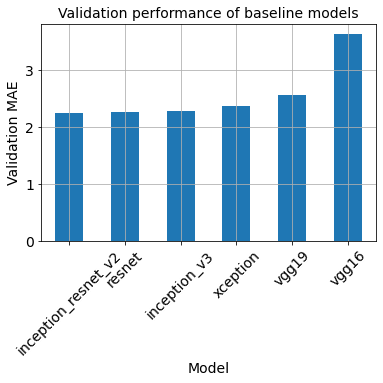

In [ ]:
plot_validation_results(comparison_data['validation_results'])

# Comparison of model parameters

In [ ]:
comparison_data['model_parameters']

{'resnet': {'Total parameters': 24568113,
  'Trainable parameters': 24514993,
  'Non-trainable parameters': 53120},
 'xception': {'Total parameters': 21841881,
  'Trainable parameters': 21787353,
  'Non-trainable parameters': 54528},
 'inception_v3': {'Total parameters': 22783185,
  'Trainable parameters': 22748753,
  'Non-trainable parameters': 34432},
 'inception_resnet_v2': {'Total parameters': 55112337,
  'Trainable parameters': 55051793,
  'Non-trainable parameters': 60544},
 'vgg16': {'Total parameters': 15080689,
  'Trainable parameters': 15080689,
  'Non-trainable parameters': 0},
 'vgg19': {'Total parameters': 20390385,
  'Trainable parameters': 20390385,
  'Non-trainable parameters': 0}}

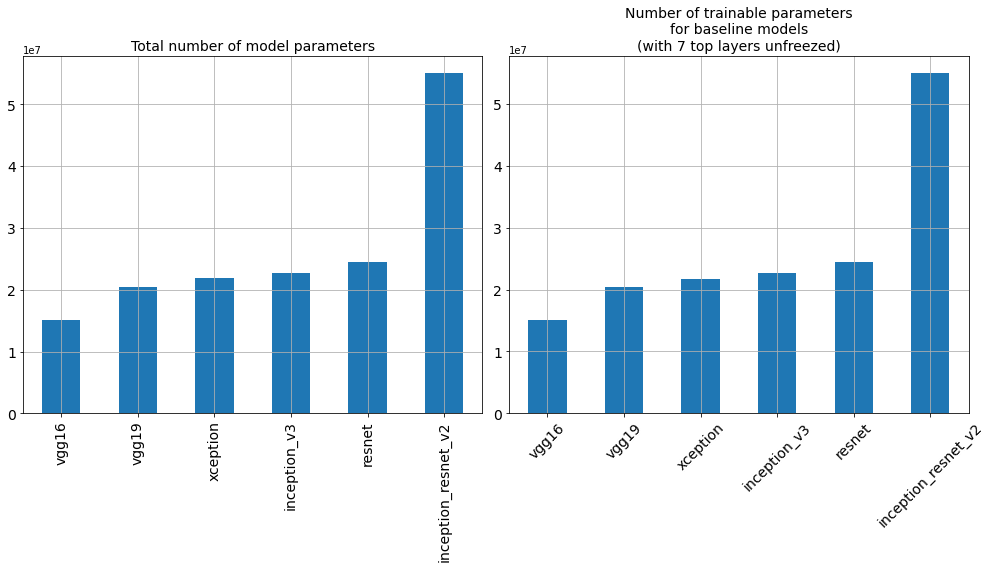

In [ ]:
plot_model_parameters(comparison_data['model_parameters'])

# Visualizing learning curves

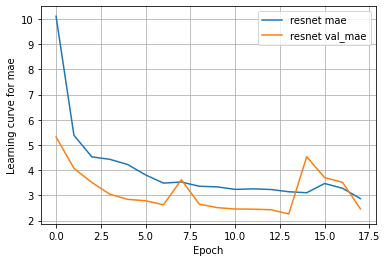

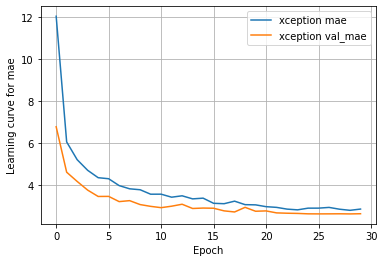

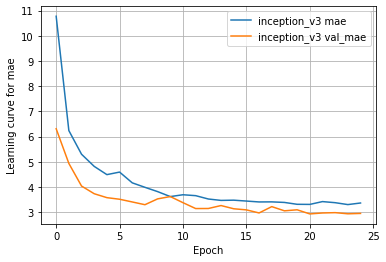

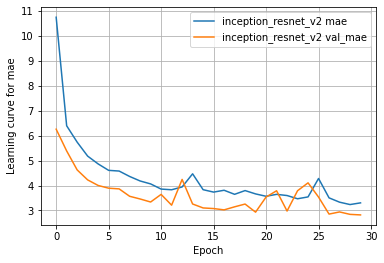

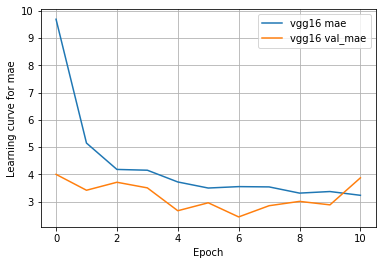

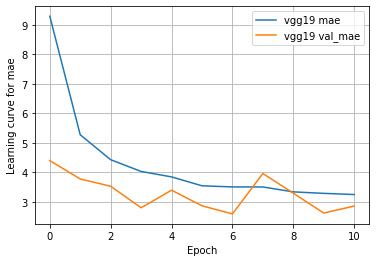

In [ ]:
for model_name, model_object in MODELS.items():
    plot_history(
        {
            model_object.name: os.path.join(
                manager.models_trial_path, f'{model_object.name}.csv'
            )
        },
        metrics_='mae'
    )

# Comparison of validation learning curves

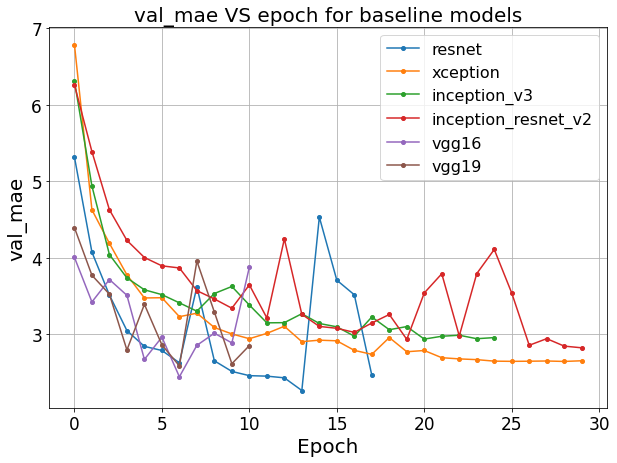

In [ ]:
compare_learning_curve(
    {
        model_name: os.path.join(
            manager.models_trial_path,
            f'{model_object.name}.csv'
        )
        for model_name, model_object in MODELS.items()
    },
    metrics_='val_mae'
)

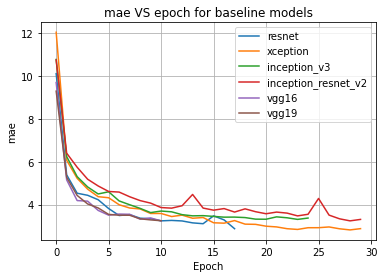

In [ ]:
compare_learning_curve(
    {
        model_name: os.path.join(
            manager.models_trial_path,
            f'{model_object.name}.csv'
        )
        for model_name, model_object in MODELS.items()
    },
    metrics_='mae'
)

# Comparison of training time

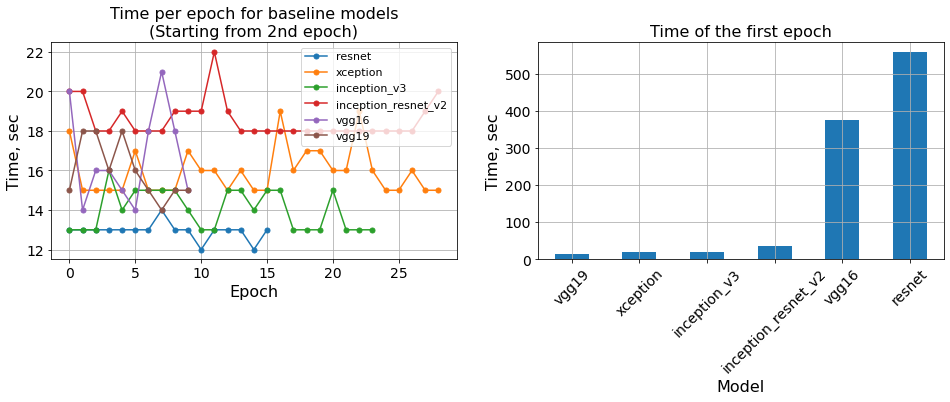

In [ ]:
training_times = {
    'resnet': [
        558, 13, 13,
        13, 13, 13,
        13, 13, 14,
        13, 13, 12,
        13, 13, 13, 12, 13],
    'xception': [
        19, 18, 15, 15, 15, 15, 17, 15, 15, 15,
        17, 16, 16, 15, 16, 15, 15, 19, 16, 17, 17,
        16, 16, 19, 16, 15, 15, 16, 15, 15
    ],
    'inception_v3': [
        21, 13, 13, 13, 16, 14, 15, 15, 15, 15, 14, 13, 13,
        15, 15, 14, 15, 15, 13, 13, 13, 15, 13, 13, 13
    ],
    'inception_resnet_v2': [
        36, 20, 20, 18, 18, 19, 18, 18, 18, 19, 19, 19,
        22, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 19, 20
    ],
    'vgg16': [
        377, 20, 14, 16, 16, 15, 14, 18, 21, 18, 15
    ],
    'vgg19': [
        16, 15, 18, 18, 16, 18,
        16, 15, 14, 15, 15
    ]
}

visualize_training_times(training_times)

# Generalization ability VS number of unfreezed layers

In [ ]:
filenames = [
    f'xception_{i}_unfreezed_layers' for i in [
        7, 10, 15, 20, 40, 60, 85
    ]
]
csv_files_dict = {
    f: f'{f}.csv' for f in filenames
}
csv_files_dict

{'xception_7_unfreezed_layers': 'xception_7_unfreezed_layers.csv',
 'xception_10_unfreezed_layers': 'xception_10_unfreezed_layers.csv',
 'xception_15_unfreezed_layers': 'xception_15_unfreezed_layers.csv',
 'xception_20_unfreezed_layers': 'xception_20_unfreezed_layers.csv',
 'xception_40_unfreezed_layers': 'xception_40_unfreezed_layers.csv',
 'xception_60_unfreezed_layers': 'xception_60_unfreezed_layers.csv',
 'xception_85_unfreezed_layers': 'xception_85_unfreezed_layers.csv'}

## Plotting learning curves

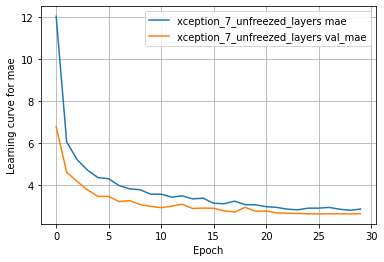

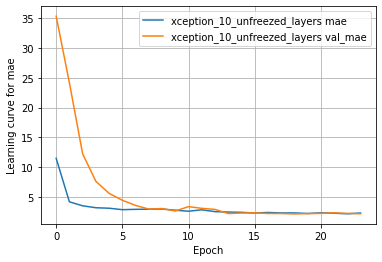

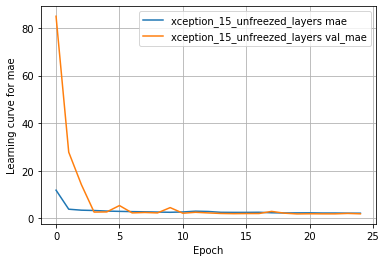

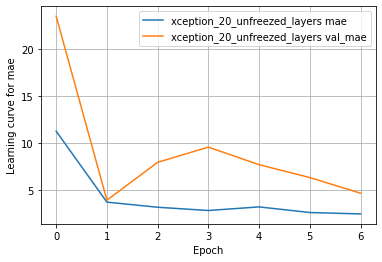

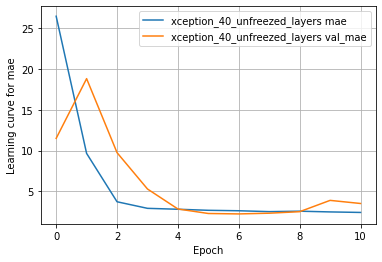

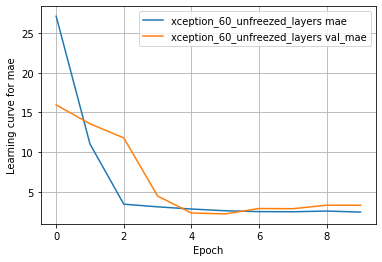

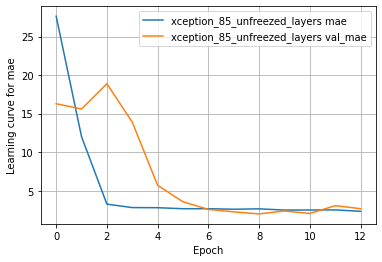

In [ ]:
for model_name, csv_filepath in csv_files_dict.items():
    plot_history(
        {
            model_name: os.path.join(
                manager.models_trial_path, csv_filepath)
        },
        metrics_='mae'
    )

## Plotting validation performance

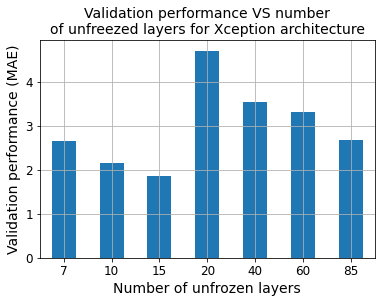

In [ ]:
plot_validation_performance_vs_unfreezed_layers('val_mae')

Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.


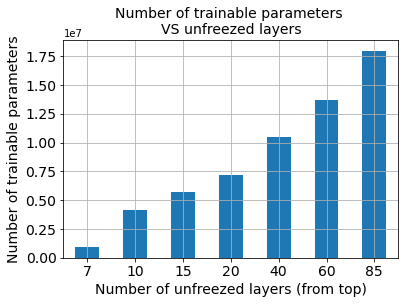

In [ ]:
plot_number_of_trainable_parameters(
    XceptionModel,
    dict(
        name_='xception',
         input_image_size_=(299, 299),
         validation_split_=0.2,
         batch_size_=64, 
         trainval_labels_df_=trainval_labels_df,
         test_labels_df_=test_labels_df
    ),
    [
        7, 10, 15, 20, 40, 60, 85
    ]
)

# Influence of pretraining on PRE dataset / Geron pretraining

In [ ]:
histories_dict_learning_curves = {
    'xception no pretraining': os.path.join(
        manager.models_trial_path,
        'xception.csv'
    ),
    'xception (842 pretraining images)': os.path.join(
        manager.models_trial_path,
        'xception_with_pretraining_842_images.csv'
    ),
    'xception (1637 pretraining images)': os.path.join(
        manager.models_trial_path,
        'xception_with_pretraining_1637_images.csv'
    ),
    # 'xception (Geron)': os.path.join(
    #     manager.models_trial_path,
    #     'xception_geron.csv'
    # )
}

histories_dict_validation_performance = {
    'xception no pretraining': os.path.join(
        manager.models_trial_path,
        'xception.csv'
    ),
    'xception (842 pretraining images)': os.path.join(
        manager.models_trial_path,
        'xception_with_pretraining_842_images.csv'
    ),
    'xception (1637 pretraining images)': os.path.join(
        manager.models_trial_path,
        'xception_with_pretraining_1637_images.csv'
    ),
    'xception (Geron)': os.path.join(
        manager.models_trial_path,
        'xception_geron.csv'
    ),
    'xception + ELU + Geron + less dropout': os.path.join(
        manager.models_trial_path,
        'xception_geron_experiment_elu.csv'
    )
}

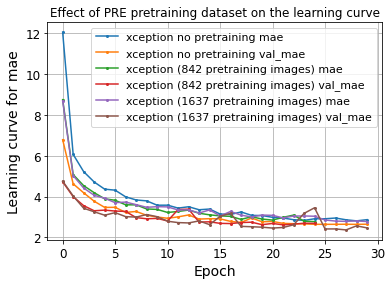

In [ ]:
plot_history(
    histories_dict_learning_curves,
    metrics_='mae',
    title_='Effect of PRE pretraining dataset on the learning curve'
)

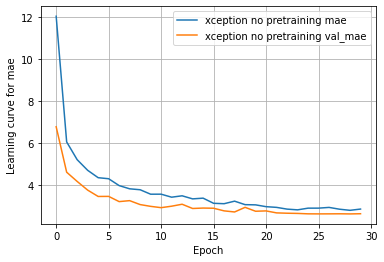

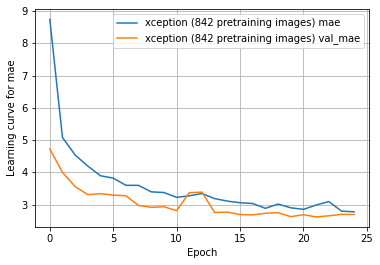

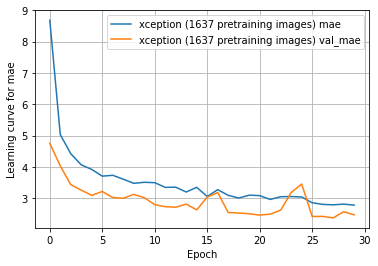

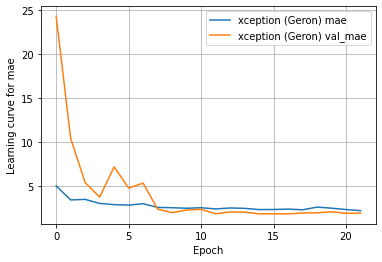

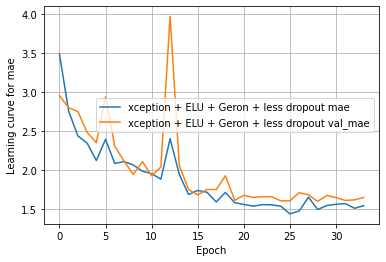

In [ ]:
for model_name, csv_filepath in histories_dict_validation_performance.items():
    plot_history(
        {
            model_name: os.path.join(
                manager.models_trial_path, csv_filepath)
        },
        metrics_='mae'
    )

In [ ]:
validation_performances = {}
for configuration, df_filepath in histories_dict_validation_performance.items():
    df = pd.read_csv(df_filepath)
    validation_performances[configuration] = [df['val_mae'].values[-1]]

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

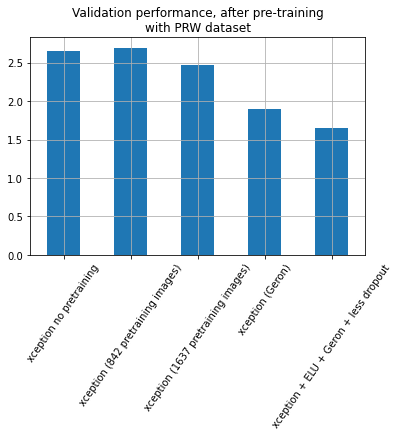

In [ ]:
ax = pd.DataFrame(validation_performances).T.plot(kind='bar')
ax.get_legend().remove()
ax.grid()
ax.set_title(
    'Validation performance, after pre-training\nwith PRW dataset'
)
plt.xticks(rotation=55)

In [ ]:
labels_original = pd.read_csv(
    os.path.join(
        manager.data_root_path,
        'labels.csv'
    )
)
labels_pretraining = pd.read_csv(
    os.path.join(
        manager.data_root_path,
        'labels_pretraining.csv'
    )
)

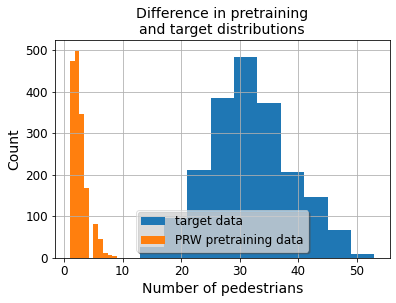

In [ ]:
fontsize = 14
legend_size = 12
labelsize = 12
_, ax = plt.subplots()
ax.hist(labels_original['count'], density=False, label='target data')  # .hist()
ax.hist(labels_pretraining['count'], density=False, label='PRW pretraining data')
ax.set_title(
    f'Difference in pretraining\nand target distributions',
    fontsize=fontsize
)
ax.set_xlabel(f'Number of pedestrians', fontsize=fontsize)
ax.set_ylabel(f'Count', fontsize=fontsize)
ax.legend(shadow=True, loc='lower center', prop={'size':legend_size}, framealpha=0.6)
ax.tick_params(labelsize=labelsize)
ax.grid()